In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import psycopg2
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

pd.set_option('display.max_columns',None)

In [23]:
# 데이터베이스 연결 설정
conn = psycopg2.connect(database="postgres", user="postgres", password="postgres123", host="postgres.c4brhfvhrm5g.ap-northeast-2.rds.amazonaws.com", port=5432)

# 빈 데이터 프레임 만들기
df_order = pd.DataFrame()
df_order_items = pd.DataFrame()
df_payments = pd.DataFrame()
df_products = pd.DataFrame()
df_customers = pd.DataFrame()
df_sellers = pd.DataFrame()
df_closed_deals = pd.DataFrame()
df_mql = pd.DataFrame()
df_geoloc = pd.DataFrame()
df_reviews = pd.DataFrame()

# DB에서 데이터를 가져와 데이터프레임으로 만들기
def make_df(df, db_table):
    cur = conn.cursor()
    query = 'SELECT * FROM ' + db_table
    cur.execute(query)
    temp = cur.fetchall()
    df = pd.DataFrame(temp, columns=[desc[0] for desc in cur.description])
    cur.close()
    return df

df_order = make_df(df_order, '"order"')
df_order_items = make_df(df_order_items, 'order_items')
df_payments = make_df(df_payments, 'payments')
df_products = make_df(df_products, 'products')
df_customers = make_df(df_customers, 'customers')
df_sellers = make_df(df_sellers, 'sellers')
df_closed_deals = make_df(df_closed_deals, 'closed_deals')
df_mql = make_df(df_mql, 'mql')
df_geoloc = make_df(df_geoloc, 'geoloc')
df_reviews = make_df(df_reviews, 'reviews')

In [24]:
# 2018년 8월까지의 데이터만 사용하기
end_date = '2018-08-31'
df_order = df_order[df_order['order_purchase_timestamp'] <= end_date]

# 조건에 맞는 order_status를 가진 데이터만 추출
order_status = ["delivered", "shipped", "invoiced", "processing"]
df_order_filtered= df_order[df_order["order_status"].isin(order_status)]

## 평균 고객 수명

In [25]:
order_total = df_order_filtered.merge(df_order_items, on='order_id',how='right')
order_total=order_total.sort_values(by=['seller_id','order_purchase_timestamp']).reset_index(drop=True)

df_origin = pd.merge(df_closed_deals, df_mql, on='mql_id', how='inner')

 # 유료채널,무료채널로 나누어 'origin_seg'컬럼 생성 및 unknown, dark_traffic 필터링
def classify_origin(origin):
    if origin == 'organic_search':
        return 'free'
    elif origin in ['social', 'paid_search', 'email', 'referral', 'display', 'other_publicities']:
        return 'paid'
    else:
        return 'none' # unknown, dark_traffic 

df_origin['origin_seg'] = df_origin['origin'].apply(classify_origin)
df_origin_filtered = df_origin[df_origin['origin_seg'] != 'none'] # unknown, dark_traffic 필터링

merged_data = pd.merge(df_origin_filtered, df_order_items, on='seller_id', how='left')

In [26]:
# 평균고객수명구하는과정
seller_order = order_total.groupby('seller_id').agg({'order_purchase_timestamp':['first','last']}).reset_index()
seller_order['diff'] = (seller_order[('order_purchase_timestamp',  'last')]-seller_order[('order_purchase_timestamp', 'first')]).dt.days
seller_order.columns = ['seller_id', 'first_last', 'last_last', 'diff']
seller_order

,seller_id,first_last,last_last,diff
0,0,2017-02-06 16:00:46,2018-08-21 13:32:24,560.00
1,1,2017-02-07 13:59:49,2017-03-20 20:31:35,41.00
2,2,2017-07-12 23:03:19,2018-06-24 20:40:44,346.00
3,3,2017-01-29 13:42:10,2017-03-13 22:19:52,43.00
4,4,2017-07-19 23:37:44,2018-01-29 19:03:39,193.00
...,...,...,...,...
3090,3552,2017-03-21 16:03:34,2018-07-25 16:11:44,491.00
3091,3553,2018-04-30 16:52:39,2018-04-30 16:52:39,0.00
3092,3554,2018-04-28 17:05:06,2018-08-08 16:54:04,101.00
3093,3555,2017-01-14 15:42:20,2018-08-13 18:42:05,576.00


In [27]:
df_orders_payments = df_order.merge(df_payments, on="order_id")

df_orders_full = df_orders_payments.merge(df_order_items, on="order_id")

# 판매자별 총 수익
seller_revenue = df_orders_full.groupby("seller_id")["payment_value"].sum()


df_origin_filtered = df_origin_filtered.merge(seller_revenue, on="seller_id", how="left")

# origin_seg별 LTV
ltv = df_origin_filtered.groupby("origin_seg")["payment_value"].mean().round(2)
ltv

origin_seg
free   2599.21
paid   2357.21
Name: payment_value, dtype: float64

In [28]:
# 'paid' 채널을 통한 판매자의 총 수익에서 마케팅 비용을 계산합니다.
df_origin_filtered.loc[df_origin_filtered["origin_seg"] == "paid", "marketing_cost"] = df_origin_filtered["payment_value"] * 0.09
df_origin_filtered.loc[df_origin_filtered["origin_seg"] == "free", "marketing_cost"] = 0

# 판매자 수를 계산하여 origin_seg 별로 나눕니다.
num_sellers = df_origin_filtered["origin_seg"].value_counts()

# CAC를 계산합니다.
cac2 = (df_origin_filtered.groupby("origin_seg")["marketing_cost"].sum()) / num_sellers
cac2 

origin_seg
free    0.00
paid   99.40
dtype: float64

In [29]:
# LTV 계산
ltv = df_origin_filtered.groupby("origin_seg")["payment_value"].sum() / num_sellers

# CAC 계산
df_origin_filtered.loc[df_origin_filtered["origin_seg"] == "paid", "marketing_cost"] = df_origin_filtered["payment_value"] * 0.09
df_origin_filtered.loc[df_origin_filtered["origin_seg"] == "free", "marketing_cost"] = 0
cac = (df_origin_filtered.groupby("origin_seg")["marketing_cost"].sum()) / num_sellers

# ROI 계산
roi = ((ltv - cac) / cac) * 100
roi

origin_seg
free       inf
paid   1011.11
dtype: float64

In [30]:
seller_origin = merged_data[['seller_id','origin']].drop_duplicates()
tmp = seller_origin.merge(seller_order, on='seller_id',how='inner')
tmp.groupby('origin')['diff'].mean()

origin
display          58.50
email            30.67
organic_search   64.27
paid_search      60.83
referral         76.11
social           57.29
Name: diff, dtype: float64

In [31]:
merged_data = pd.merge(df_origin_filtered, df_order_items, on='seller_id', how='left')
origin_sales = merged_data.groupby('origin')['payment_value'].sum()
origin_sellers = merged_data.groupby('origin')['seller_id'].nunique()

In [32]:
merged_data.groupby('origin').agg({'payment_value':'sum', 'seller_id':'nunique'}).reset_index()

,origin,payment_value,seller_id
0,display,6527.80,6
1,email,44164.46,15
2,organic_search,10299262.99,271
3,other_publicities,0.00,3
4,paid_search,27620332.44,195
5,referral,268819.00,24
6,social,3215016.61,75


In [55]:
# 평균 판매빈도를 보기위한 과정
seller_order_id_count = order_total.groupby('seller_id')['order_id'].count()
seller_tmp = seller_origin.merge(seller_order_id_count, on='seller_id',how='inner')
seller_tmp2= seller_tmp.groupby('origin')['order_id'].count().reset_index()

# 소수점 2자리까지 표현
pd.set_option('display.float_format', lambda x: '%.2f' % x)
grouped_data = merged_data.groupby('origin').agg({'payment_value':'sum', 'seller_id':'nunique'}).reset_index()

# 마케팅 비용 (매출의 9%로 가정) 
grouped_data['marketing_cost'] = grouped_data['payment_value'] * 0.1

# 평균판매금액 (기존버전): 매출 / 판매자 수
grouped_data['평균판매금액'] = grouped_data['payment_value'] * 0.09 / grouped_data['seller_id']

# 평균고객수명 데이터
avg_customer_lifetime = tmp.groupby('origin')['diff'].mean().reset_index(name='평균고객수명')

#  LTV(수명반영버전)
grouped_data = pd.merge(grouped_data, avg_customer_lifetime, on='origin', how='left')

result = grouped_data.merge(seller_tmp2,on='origin',how='left').fillna(0)
result['평균판매빈도'] = result['order_id'] / result['seller_id']
result['LTV'] = result['평균판매금액'] * result['평균고객수명'] * result['평균판매빈도']

result = result.fillna(0)
result['marketing_cost'] = grouped_data['marketing_cost']
result = result.merge(df_mql.groupby('origin')['mql_id'].count().reset_index(name='total_seller'),on='origin',how='left')
result['전환율'] = result['seller_id'] / result['total_seller'] *100
result['CAC'] = result['marketing_cost'] / result['seller_id']
result.loc[result['origin'] == 'organic_search', 'CAC'] = 0
result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','CAC','LTV','total_seller','전환율']]

,origin,payment_value,평균판매금액,평균고객수명,평균판매빈도,CAC,LTV,total_seller,전환율
0,display,6527.80,97.92,58.50,0.33,108.80,1909.38,118,5.08
1,email,44164.46,264.99,30.67,0.40,294.43,3250.50,493,3.04
2,organic_search,10299262.99,3420.42,64.27,0.42,0.00,91660.52,2296,11.80
3,other_publicities,0.00,0.00,0.00,0.00,0.00,0.00,65,4.62
4,paid_search,27620332.44,12747.85,60.83,0.52,14164.27,401655.20,1586,12.30
5,referral,268819.00,1008.07,76.11,0.38,1120.08,28772.03,284,8.45
6,social,3215016.61,3858.02,57.29,0.41,4286.69,91357.91,1350,5.56


In [56]:
TMP = result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','LTV','CAC','total_seller','전환율']]
TMP['LTV/CAC ratio'] = TMP['LTV']/TMP['CAC']
TMP = TMP.fillna(0)
TMP['LTV/CAC ratio'] = TMP['LTV/CAC ratio'].replace([np.inf, -np.inf], 0)
TMP = TMP[TMP.origin!='organic_search']
TMP

C:\Users\KIMJEONGSU.DESKTOP-3GN3AD1\AppData\Local\Temp\ipykernel_22052\2233834344.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,origin,payment_value,평균판매금액,평균고객수명,평균판매빈도,LTV,CAC,total_seller,전환율,LTV/CAC ratio
0,display,6527.80,97.92,58.50,0.33,1909.38,108.80,118,5.08,17.55
1,email,44164.46,264.99,30.67,0.40,3250.50,294.43,493,3.04,11.04
3,other_publicities,0.00,0.00,0.00,0.00,0.00,0.00,65,4.62,0.00
4,paid_search,27620332.44,12747.85,60.83,0.52,401655.20,14164.27,1586,12.30,28.36
5,referral,268819.00,1008.07,76.11,0.38,28772.03,1120.08,284,8.45,25.69
6,social,3215016.61,3858.02,57.29,0.41,91357.91,4286.69,1350,5.56,21.31


In [57]:
# 그래프 생성
fig = px.bar(TMP.sort_values('LTV/CAC ratio',ascending=False), x='origin', y='LTV/CAC ratio', title='유입경로별 LTV/CAC ratio')

# 특정 막대 그래프에만 색상 적용
fig.update_traces(marker_color='#4A55A2')
# x축 레이블 변경
fig.update_xaxes(title_text='유입채널')
# 그래프 표시
fig.show()

In [58]:
import plotly.express as px

# TMP 데이터프레임을 이용하여 그래프 생성
fig = px.bar(TMP.sort_values('CAC', ascending=False), x='origin', y='CAC', title='유입 채널별 CAC')

# CAC의 평균값 계산
mean_cac = TMP['CAC'].mean()
fig.update_traces(marker_color='#4A55A2')

# 가로선 추가 (평균값)
fig.add_shape(
    type='line',
    x0=-0.5,
    x1=len(TMP['origin']) - 0.5,
    y0=mean_cac,
    y1=mean_cac,
    line=dict(color='red', dash='dot')
)

# 평균값 텍스트 추가 (오른쪽으로 이동)
fig.add_annotation(
    x=1.5,  # X 좌표를 조정하여 오른쪽으로 이동
    y=mean_cac,
    text=f'평균 CAC: {mean_cac:.2f}',  # 평균값을 글씨로 추가
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    arrowsize=1.5,
    ax=50,  # 더 큰 값으로 설정하여 오른쪽으로 이동
    ay=-50
)
# x축 레이블 변경
fig.update_xaxes(title_text='유입채널')

# 그래프 표시
fig.show()


In [43]:
df_combined = pd.concat([origin_sales, origin_sellers], axis=1)
df_combined.columns = ['Sales', 'Sellers']
df_combined['Sales/Sellers'] = df_combined['Sales']/df_combined['Sellers']
conversion_rates = df_mql.groupby('origin')['mql_id'].count().reset_index(name='total_seller')

df_combined = df_combined.merge(conversion_rates,on='origin',how='left')
df_combined['conversion_rates'] = df_combined['Sellers']/df_combined['total_seller']*100

In [44]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 프레임 생성
data = {
    'origin': ['display', 'email', 'organic_search', 'other_publicities', 'paid_search', 'referral', 'social'],
    '평균판매금액': [97.92, 264.99, 3420.42, 0.00, 12747.85, 1008.07, 3858.02],
    '평균고객수명': [58.50, 30.67, 64.27, 0.00, 60.83, 76.11, 57.29],
    '평균판매빈도': [1.17, 1.60, 4.97, 0.00, 7.43, 3.21, 5.92]
}

df = pd.DataFrame(data)

# Min-Max 스케일러 생성
scaler = MinMaxScaler()

# '평균판매금액', '평균고객수명', '평균판매빈도' 열에 Min-Max 스케일링 적용
df[['평균판매금액', '평균고객수명', '평균판매빈도']] = scaler.fit_transform(df[['평균판매금액', '평균고객수명', '평균판매빈도']])

# 결과 출력
print(df)

              origin  평균판매금액  평균고객수명  평균판매빈도
0            display    0.01    0.77    0.16
1              email    0.02    0.40    0.22
2     organic_search    0.27    0.84    0.67
3  other_publicities    0.00    0.00    0.00
4        paid_search    1.00    0.80    1.00
5           referral    0.08    1.00    0.43
6             social    0.30    0.75    0.80


In [45]:
fig = go.Figure()

# 평균판매금액 막대 그래프 추가 (파란색)
fig.add_trace(go.Bar(x=df['origin'], y=df['평균판매금액'], name='평균판매금액', marker_color='#4A55A2'))

# 평균고객수명 막대 그래프 추가 (녹색)
fig.add_trace(go.Bar(x=df['origin'], y=df['평균고객수명'], name='평균고객수명', marker_color='#7895CB'))

# 평균판매빈도 막대 그래프 추가 (주황색)
fig.add_trace(go.Bar(x=df['origin'], y=df['평균판매빈도'], name='평균판매빈도', marker_color='#A0BFE0'))

# 레이아웃 설정
fig.update_layout(
    title='평균판매금액, 평균고객수명, 평균판매빈도 비교',
    xaxis=dict(title='유입 채널'),
    yaxis=dict(title='값 (Min-Max 스케일링)'),
    barmode='group'
)

# 그래프 표시
fig.show()



In [47]:
df_combined_tmp = result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','LTV','전환율']].sort_values('payment_value',ascending=False).reset_index(drop=True).set_index('origin')
df_combined_tmp2 = df_combined_tmp#[df_combined_tmp.index!='organic_search']

# plotly 그래프 생성
fig = go.Figure()

# 막대 그래프 추가 (primary y-axis: Sales Value)
fig.add_trace(go.Bar(
    x=df_combined_tmp2.index, 
    y=df_combined_tmp2['payment_value'], 
    name='매출',
    marker_color='#A0BFE0',
))

# 라인2 그래프 추가 (secondary y-axis: Number of Sellers)
fig.add_trace(go.Scatter(
    x=df_combined_tmp2.index, 
    y=df_combined_tmp2['전환율'], 
    name='전환율',
    yaxis='y2',  # secondary y-axis
    mode='lines+markers',
    line=dict(color='#4A55A2')
))

# 레이아웃 설정
fig.update_layout(
    title = '유입경로별 매출과 전환율',
    yaxis=dict(
        title='매출',
    ),
    yaxis2=dict(
        title='전환율',
        overlaying='y',
        side='right'
    ),

    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    )
)

fig.show()

In [50]:
df_combined_tmp = result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','LTV']].sort_values('payment_value',ascending=False).reset_index(drop=True).set_index('origin')
df_combined_tmp2 = df_combined_tmp[df_combined_tmp.index!='organic_search']

# plotly 그래프 생성
fig = go.Figure()

# 막대 그래프 추가 (primary y-axis: Sales Value)
fig.add_trace(go.Bar(
    x=df_combined_tmp2.index, 
    y=df_combined_tmp2['payment_value'], 
    name='매출',
    marker_color='#A0BFE0',
))

# 라인2 그래프 추가 (secondary y-axis: Number of Sellers)
fig.add_trace(go.Scatter(
    x=df_combined_tmp2.index, 
    y=df_combined_tmp2['LTV'], 
    name='LTV',
    yaxis='y2',  # secondary y-axis
    mode='lines+markers',
    line=dict(color='#4A55A2')
))

# 레이아웃 설정
fig.update_layout(
    title = '유입경로별 매출과 LTV',
    yaxis=dict(
        title='매출',
    ),
    yaxis2=dict(
        title='LTV',
        overlaying='y',
        side='right'
    ),

    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    )
)
# x축 레이블 변경
fig.update_xaxes(title_text='유입채널')
fig.show()

In [138]:
df_combined_tmp = result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','LTV','total_seller']].sort_values('payment_value',ascending=False).reset_index(drop=True).set_index('origin')
df_combined_tmp2 = df_combined_tmp[df_combined_tmp.index!='organic_search']

# plotly 그래프 생성
fig = go.Figure()

# 막대 그래프 추가 (primary y-axis: Sales Value)
fig.add_trace(go.Bar(
    x=df_combined_tmp.index, 
    y=df_combined_tmp['payment_value'], 
    name='매출',
    marker_color='#A0BFE0',
))

# 라인2 그래프 추가 (secondary y-axis: Number of Sellers)
fig.add_trace(go.Scatter(
    x=df_combined_tmp.index, 
    y=df_combined_tmp['total_seller'], 
    name='잠재고객 수',
    yaxis='y2',  # secondary y-axis
    mode='lines+markers',
    line=dict(color='#4A55A2')
))

# 레이아웃 설정
fig.update_layout(
    title = '유입경로별 매출과 잠재고객',
    yaxis=dict(
        title='매출',
    ),
    yaxis2=dict(
        title='잠재고객',
        overlaying='y',
        side='right'
    ),

    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    )
)

fig.show()

              origin  payment_value   평균판매금액  평균고객수명  평균판매빈도       LTV  \
0            display        6527.80    97.92   58.50    0.33   1909.38   
1              email       44164.46   264.99   30.67    0.40   3250.50   
2     organic_search    10299262.99  3420.42   64.27    0.42  91660.52   
3  other_publicities           0.00     0.00    0.00    0.00      0.00   
4        paid_search    27620332.44 12747.85   60.83    0.52 401655.20   
5           referral      268819.00  1008.07   76.11    0.38  28772.03   
6             social     3215016.61  3858.02   57.29    0.41  91357.91   

        Sales  Sellers  Sales/Sellers  total_seller  conversion_rates  
0     6527.80        6        1087.97           118              5.08  
1    44164.46       15        2944.30           493              3.04  
2 10299262.99      271       38004.66          2296             11.80  
3        0.00        3           0.00            65              4.62  
4 27620332.44      195      141642.73          

Text(0.5, 1.0, '매출과 LTV의 상관관계')

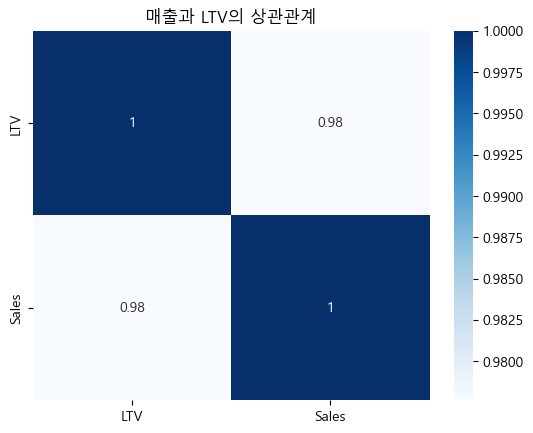

In [20]:
total = result[['origin','payment_value','평균판매금액','평균고객수명','평균판매빈도','LTV']]
total = total.merge(df_combined,on='origin',how='left')
print(total)
sns.heatmap(total[['origin','LTV','Sales']].set_index('origin').corr(), annot=True, cmap='Blues')
plt.title('매출과 LTV의 상관관계')

Text(0.5, 1.0, '매출과 전환율의 상관관계')

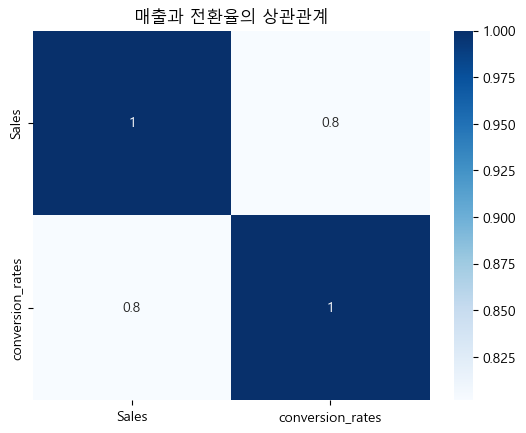

In [21]:
sns.heatmap(df_combined[['Sales', 'conversion_rates']].corr(), annot=True, cmap='Blues')
plt.title('매출과 전환율의 상관관계')